In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def drawModel1D(ax, thickness=None, values=None, model=None, depths=None,
                plot='plot',
                xlabel=r'Resistivity $(\Omega$m$)$', zlabel='Depth (m)',
                z0=0,
                **kwargs):
    """Draw 1d block model into axis ax.

    Draw 1d block model into axis ax defined by values and thickness vectors
    using plot function.
    For log y cases, z0 should be set > 0 so that the default becomes 1.

    Parameters
    ----------
    ax : mpl axes
        Matplotlib Axes object to plot into.

    values : iterable [float]
        [N] Values for each layer plus lower background.

    thickness : iterable [float]
        [N-1] thickness for each layer. Either thickness or depths must be set.

    depths : iterable [float]
        [N-1] Values for layer depths (positive z-coordinates).
        Either thickness or depths must be set.

    model : iterable [float]
        Shortcut to use default model definition.
        thks = model[0:nLay]
        values = model[nLay:]

    plot : string
        Matplotlib plotting function.
        'plot', 'semilogx', 'semilogy', 'loglog'

    xlabel : str
        Label for x axis.

    ylabel : str
        Label for y axis.

    z0 : float
        Starting depth in m

    **kwargs : dict()
        Forwarded to the plot routine

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> import pygimli as pg
    >>> # plt.style.use('ggplot')
    >>> thk = [1, 4, 4]
    >>> res = np.array([10., 5, 15, 50])
    >>> fig, ax = plt.subplots()
    >>> pg.viewer.mpl.drawModel1D(ax, values=res*5, depths=np.cumsum(thk),
    ...                          plot='semilogx', color='blue')
    >>> pg.viewer.mpl.drawModel1D(ax, values=res, thickness=thk, z0=1,
    ...                          plot='semilogx', color='red')
    >>> pg.wait()
    """
    if model is not None:
        nLayers = (len(model)-1)//2
        thickness = model[:nLayers]
        values = model[nLayers:]

    if thickness is None and depths is None:
        raise Exception("Either thickness or depths must be given.")

    nLayers = len(values)
    px = np.zeros(nLayers * 2)
    pz = np.zeros(nLayers * 2)

    if thickness is not None:
        z1 = np.cumsum(thickness) + z0
    else:
        z1 = depths

    for i in range(nLayers):
        px[2 * i] = values[i]
        px[2 * i + 1] = values[i]

        if i == nLayers - 1:
            pz[2 * i + 1] = z1[i - 1] * 1.2
        else:
            pz[2 * i + 1] = z1[i]
            pz[2 * i + 2] = z1[i]

    if plot == 'loglog' or plot == 'semilogy':
        if z0 == 0:
            pz[0] = z1[0] / 2.
        else:
            pz[0] = z0

    try:
        plot = getattr(ax, plot)
        plot(px, pz+z0, **kwargs)
    except BaseException as e:
        print(e)

    ax.set_ylabel(zlabel)
    ax.set_xlabel(xlabel)
    # assume positive depths pointing upward
    ax.set_ylim(pz[-1], pz[0])
    ax.grid(True)

In [ ]:
def Modelo(n = 10, depth_max = 100):

    dz = depth_max / (n - 1)
    z = np.arange(n) * dz
    espesores = np.diff(z)

    return espesores

In [ ]:
synres = tf.constant([100, 60, 20, 800, 30, 200], dtype = tf.float64)
synthk = Modelo(n= len(synres), depth_max=20)

#synthk = tf.constant([0.57, 1.96, 2.8, 18.4], dtype=tf.float64)
#syncon = tf.math.reciprocal(tf.constant([103, 538, 261, 51.4, 1274], dtype=tf.float64))

In [ ]:
synthk

array([4., 4., 4., 4., 4.])

In [ ]:
@tf.function
def forward(res):
    """
    Calculate forward VES response with half the current electrode spacing for a 1D layered earth.

    Parameters
    ----------
    con : tf.Tensor, (n,)
        Electrical conductivity of n layers (S/m), last layer n is assumed to be infinite

    thick : tf.Tensor, (n-1,)
        Thickness of n-1 layers (m), last layer n is assumed to be infinite and does not require a thickness

    ab2 : float
        Half the current (AB/2) electrode spacing (m)

    Returns
    -------
    app_con : tf.Tensor, (m,)
        Apparent half-space electrical conductivity (S/m)
    """
    # Conductivity to resistivity and number of layers
    ab2 = tf.cast(np.logspace(-1, 2.5, 50), dtype=tf.float64)
    #res = tf.math.reciprocal(tf.cast(con, dtype=tf.float64))
    lays = tf.shape(res)[0] - 1
    thick =tf.cast(synthk,dtype=tf.float64)

    # Constants
    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    # Filter integral variable
    up = ab2 * tf.exp(-10.0 * LOG / 4.438)

    # Initialize array
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        # Set bottom layer equal to its resistivity
        ti1 = tf.fill(tf.shape(up), res[lays])

        # Recursive formula (Koefoed, 1970)
        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(tf.cast(thick[lay], dtype=tf.float64) / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        # Set overlaying layer to previous
        ti = ti.write(ii, ti1)

        # Update filter integral variable
        up *= UP

    # The following line was incorrectly indented, causing the error.
    ti = ti.stack()  # Shape: (COUNTER, len(ab2))

    # Apply point-filter weights (Nyman and Landisman, 1977)
    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841, 0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    # Resistivity to conductivity
    return res_a

In [ ]:
rhoa = forward(synres)

In [ ]:
rhoa

<tf.Tensor: shape=(50,), dtype=float64, numpy=
array([100.        , 100.        , 100.        ,  99.99999997,
        99.99999953,  99.99999561,  99.99997093,  99.99985537,
        99.99943368,  99.9981847 ,  99.99506677,  99.98827769,
        99.97497666,  99.95087865,  99.90957478,  99.84143657,
        99.73194551,  99.55911473,  99.28952   ,  98.87285582,
        98.23594568,  97.27825682,  95.8724071 ,  93.87544787,
        91.15738756,  87.64745312,  83.38708634,  78.57267211,
        73.57660905,  68.939966  ,  65.32098602,  63.37873386,
        63.60199826,  66.15105729,  70.80480535,  77.05550003,
        84.30129593,  92.03149432,  99.92228521, 107.83029044,
       115.72624935, 123.62061751, 131.51043246, 139.35244351,
       147.05697627, 154.49695489, 161.5276824 , 168.01162649,
       173.8408741 , 178.9510491 ])>

In [ ]:
#N=7 # numero de capas
#invthk = Modelo(n=N, depth_max=25)
VES = tf.Module()
VES.synres = tf.Variable(500*tf.ones(len(synres),dtype=tf.float64),dtype=tf.float64)
#VES.synthk = tf.constant(invthk,dtype=tf.float64)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.5)

@tf.function
def train():
    with tf.GradientTape() as tape:
        rhoa_pred = forward(VES.synres)
        J = (0.5)*tf.norm( tf.math.log(rhoa_pred) - tf.math.log(rhoa), 2)
    grads = tape.gradient(J, VES.trainable_variables)
    optimizer.apply_gradients(zip(grads, VES.trainable_variables))
    return J

In [ ]:
from tqdm import trange
loss_i = []
niter = trange(1000)
for i in niter:
  loss = train()
  niter.set_postfix(LOSS=loss.numpy())
  loss_i.append(loss.numpy())

100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s, LOSS=0.0283]


LOSS: 0.02827784840699183


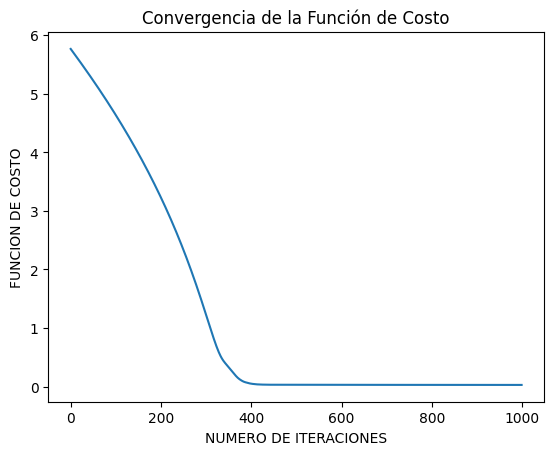

In [ ]:
plt.plot(loss_i)
plt.title('Convergencia de la Función de Costo')
plt.ylabel('FUNCION DE COSTO')
plt.xlabel('NUMERO DE ITERACIONES')
plt.savefig('convergencia_funcion_de_costo.svg', format='svg')
print(f'LOSS: {loss}')

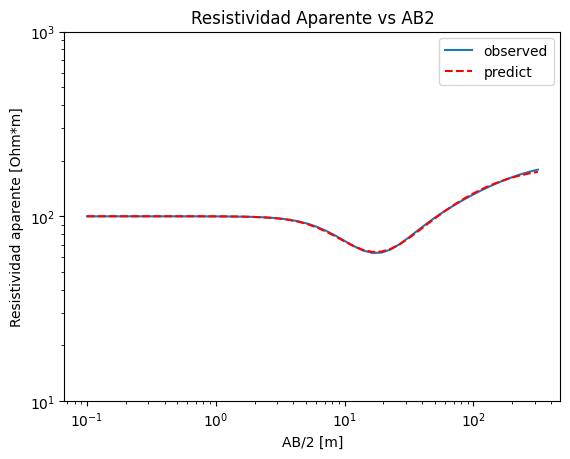

Resistividad: <tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
array([100.07188322,  53.54660985,  35.79285395,  74.68004654,
        98.18940678, 186.8547057 ])>
Espesor: [4. 4. 4. 4. 4.]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ab2 = tf.cast(np.logspace(-1, 2.5, 50), dtype=tf.float64)
plt.plot(ab2, rhoa, linestyle='-', label='observed')
plt.plot(ab2, forward(VES.synres), linestyle='dashed', label='predict', color='red')
plt.ylim(10, 1000)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('AB/2 [m]')
plt.ylabel('Resistividad aparente [Ohm*m]')
plt.title('Resistividad Aparente vs AB2')
plt.legend()
plt.savefig('resistividad_aparente_vs_ab2.svg', format='svg', transparent=True)
plt.show()

print(f'Resistividad: {VES.synres}')
print(f'Espesor: {synthk}')

from google.colab import files
files.download('resistividad_aparente_vs_ab2.svg')

<ipython-input-60-1d00dbbf2874>:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,10**3])


(16.631330580338293, 1000)

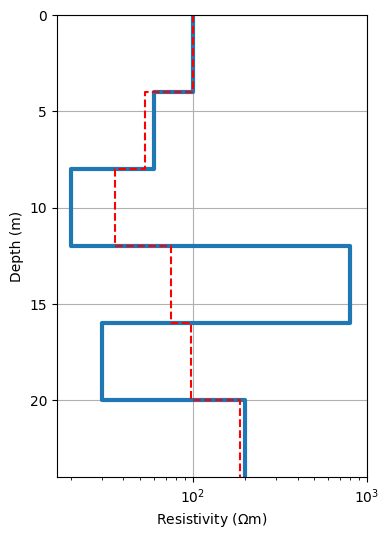

In [ ]:
fig, ax = plt.subplots(figsize=(4,6))
drawModel1D(ax, synthk, synres,plot='semilogx',linewidth=3.0)
drawModel1D(ax, synthk, VES.synres.numpy(),plot='semilogx',color='red',linestyle='dashed')
plt.savefig('/content/Modelo.svg', format='svg', transparent=True)
plt.xlim([0,10**3])